In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers, models
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
# -------------------------------
# 1. Load and Preprocess Data
# -------------------------------
# Load Dataset
file_path = 'Input_Data.csv'
df = pd.read_csv(file_path)

# Define feature and target columns
y_features = [f'y_U{i}' for i in range(0, 10)] + [f'y_L{i}' for i in range(0, 10)]
condition_features = ['alpha', 'Mach', 'Cl', 'Cm']

# Extract data
X = df[y_features].values
conditions = df[condition_features].values

# Normalize data
shape_scaler = MinMaxScaler()
condition_scaler = StandardScaler()

X_normalized = shape_scaler.fit_transform(X)
conditions_normalized = condition_scaler.fit_transform(conditions)

In [5]:
# -------------------------------
# 2. Build Conditional VAE Model
# -------------------------------
LATENT_DIM = 16
INPUT_DIM = X_normalized.shape[1]
CONDITION_DIM = conditions_normalized.shape[1]

# Encoder
condition_input = tf.keras.layers.Input(shape=(CONDITION_DIM,), name='condition_input')
shape_input = tf.keras.layers.Input(shape=(INPUT_DIM,), name='shape_input')
combined_input = tf.keras.layers.Concatenate()([shape_input, condition_input])

x = tf.keras.layers.Dense(64, activation='relu')(combined_input)
x = tf.keras.layers.Dense(32, activation='relu')(x)

z_mean = tf.keras.layers.Dense(LATENT_DIM, name='z_mean')(x)
z_log_var = tf.keras.layers.Dense(LATENT_DIM, name='z_log_var')(x)

# Sampling Layer
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], LATENT_DIM))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])

# Decoder
latent_input = tf.keras.layers.Input(shape=(LATENT_DIM,), name='latent_input')
combined_decoder_input = tf.keras.layers.Concatenate()([latent_input, condition_input])

decoder_hidden = tf.keras.layers.Dense(32, activation='relu')(combined_decoder_input)
decoder_hidden = tf.keras.layers.Dense(64, activation='relu')(decoder_hidden)
decoder_output = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(decoder_hidden)

# Models
encoder = tf.keras.Model([shape_input, condition_input], [z_mean, z_log_var, z], name='encoder')
decoder = tf.keras.Model([latent_input, condition_input], decoder_output, name='decoder')

# VAE Model
shape_decoded = decoder([z, condition_input])
vae = tf.keras.Model([shape_input, condition_input], shape_decoded, name='vae')

# Custom VAE Loss Layer
class VAELossLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        shape_input, shape_decoded, z_mean, z_log_var = inputs
        reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(shape_input, shape_decoded))
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        vae_loss = reconstruction_loss + kl_loss
        self.add_loss(vae_loss)
        return shape_decoded

# Apply the custom loss layer
shape_decoded = VAELossLayer()([shape_input, shape_decoded, z_mean, z_log_var])
vae = tf.keras.Model([shape_input, condition_input], shape_decoded, name='vae')

vae.compile(optimizer='adam')


In [6]:
# -------------------------------
# 3. Train the Model
# -------------------------------
history = vae.fit(
    [X_normalized, conditions_normalized],
    X_normalized,
    epochs=1000,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1533 - val_loss: 0.1205
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0938 - val_loss: 0.1180
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0863 - val_loss: 0.1226
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0826 - val_loss: 0.1316
Epoch 5/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0831 - val_loss: 0.1476
Epoch 6/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0760 - val_loss: 0.1612
Epoch 7/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0754 - val_loss: 0.1676
Epoch 8/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0756 - val_loss: 0.1757
Epoch 9/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0779 - val_loss: 0.1872
Epoch 10/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0724 - val_loss: 0.2021
Epoch 11/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0744 - val_loss: 0.2116
Epoch 12/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

In [7]:
# Save Models
encoder.save('encoder_model.h5')
decoder.save('decoder_model.h5')
vae.save('vae_model.h5')

In [8]:
# -------------------------------
# 4. Generate Airfoils
# -------------------------------
def generate_airfoil(condition_input):
    condition_input = condition_scaler.transform([condition_input])
    random_latent_vector = np.random.normal(size=(1, LATENT_DIM))
    generated_shape = decoder.predict([random_latent_vector, condition_input])
    return shape_scaler.inverse_transform(generated_shape)

In [9]:
# Example Usage
condition_example = [0, 0.65, 0.006904, -0.000216]  # Example aerodynamic targets
generated_airfoil = generate_airfoil(condition_example)
print("Generated Airfoil Coordinates:")
print(generated_airfoil)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Generated Airfoil Coordinates:
[[ 1.0664689e-09  4.9235832e-02  5.8132790e-02  6.0124595e-02
   5.6469828e-02  4.9499735e-02  4.0272150e-02  2.9220968e-02
   1.6451936e-02  7.7528611e-10  2.5786178e-09 -4.8268706e-02
  -5.8100127e-02 -5.9481412e-02 -5.5926904e-02 -4.9076539e-02
  -3.9937586e-02 -2.8972507e-02 -1.6327159e-02  6.0446785e-09]]


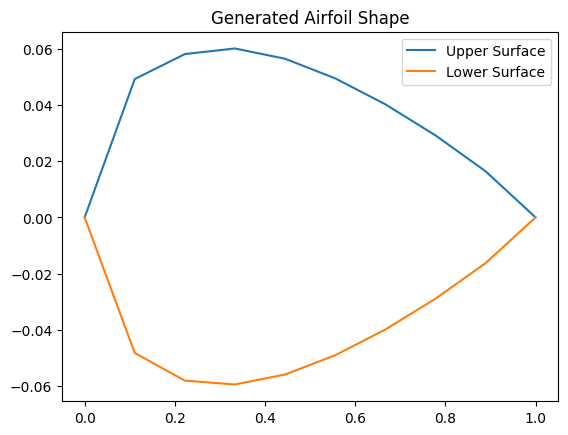

In [11]:
# -------------------------------
# 5. Visualization (Optional)
# -------------------------------
import matplotlib.pyplot as plt

def plot_airfoil(coords):
    x_coords = np.linspace(0, 1, 10)
    y_upper = coords[0, :10]
    y_lower = coords[0, 10:]
    plt.plot(x_coords, y_upper, label='Upper Surface')
    plt.plot(x_coords, y_lower, label='Lower Surface')
    plt.legend()
    plt.title('Generated Airfoil Shape')
    plt.show()

plot_airfoil(generated_airfoil)